# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.631139,False,2.100991
1,-0.009907,True,4.318753
2,0.358209,True,6.544482
3,-1.165764,False,-1.272343
4,0.022657,True,5.129812
...,...,...,...
995,-2.150297,True,2.934997
996,0.151930,True,5.832680
997,-0.658898,False,-0.369199
998,-1.417588,False,-1.946255


<AxesSubplot:xlabel='v0'>

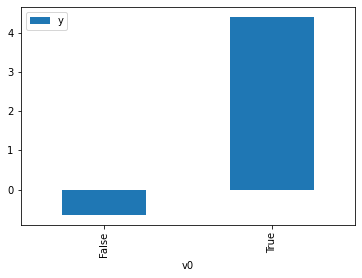

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

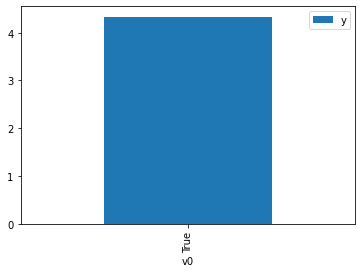

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.239286,False,-0.165813,0.518956,1.926944
1,0.314694,False,0.300549,0.463614,2.156965
2,-0.236057,False,1.067304,0.518634,1.928143
3,-1.294106,False,-1.296933,0.621971,1.607792
4,-0.583932,False,-1.412499,0.553238,1.807540
...,...,...,...,...,...
995,-0.342906,False,-0.095061,0.529297,1.889298
996,-2.203187,False,-1.573136,0.703009,1.422457
997,0.283549,False,0.761798,0.466715,2.142636
998,-0.020973,False,-0.645911,0.497127,2.011558


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.106487,True,6.748532,0.494319,2.022985
1,-0.915891,True,5.596616,0.414210,2.414234
2,0.621719,True,4.335288,0.566761,1.764412
3,-0.200344,True,4.082877,0.484935,2.062133
4,-1.799967,True,2.889441,0.331739,3.014416
...,...,...,...,...,...
995,-0.119219,True,6.409490,0.493046,2.028210
996,-0.611409,True,5.092266,0.444046,2.252019
997,-1.724439,True,4.843344,0.338472,2.954450
998,-1.560071,True,3.474281,0.353351,2.830047


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              5071.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        10:54:13   Log-Likelihood:                         -1415.2
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8395      0.025     33.139      0.000       0.790       0.889
x2             5.0490      0.050    100.586      0.000       4.950       5.147
==============================================================================
Omnibus:                        2.680   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                2.534
Skew:                          -0.107   Prob(JB):                        0.282
Kurtosis:                       3.122   Cond. No.                         2.12
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""